# Import Related Functions

In [5]:
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
import torch
from torchvision import transforms

class create_tensor_dataset(Dataset):
    
    def __init__(self, path='../contactInterpretation-main/dataset/realData/contact_detection_train.csv', num_classes=4, num_features=4):
        self.path = path
        self.num_classes = num_classes
        self.num_features = num_features

        # tau_J,tau_J_d,tau_ext,q,q_d,dq,dq_d,e,de,etau_J
        # label,block_id,touch_type

        self.read_dataset()
    
    def __len__(self):
        return len(self.data_target)


    def __getitem__(self, index:int):
        data_sample = torch.tensor(self.data_input[index])
        # print(data_sample)
        # print(data_sample.shape)
        target = torch.tensor(self.data_target[index])
        return data_sample, target

    def read_dataset(self):
        df = pd.read_csv(self.path)
        # exclude_columns = ['index', 'time', 'label', 'block_id', 'touch_type']
        
        joint0_colums = ['e0','de0','tau_J0','tau_ext0']
        joint1_colums = ['e1','de1','tau_J1','tau_ext1']
        joint2_colums = ['e2','de2','tau_J2','tau_ext2']
        joint3_colums = ['e3','de3','tau_J3','tau_ext3']
        joint4_colums = ['e4','de4','tau_J4','tau_ext4']
        joint5_colums = ['e5','de5','tau_J5','tau_ext5']
        joint6_colums = ['e6','de6','tau_J6','tau_ext6']

        joints_colums = [joint0_colums, joint1_colums, joint2_colums, joint3_colums, joint4_colums, joint5_colums, joint6_colums]

        grouped = df.groupby('block_id')

        self.data_input = []
        self.data_target = []

        for block_id, group in grouped:
            # encoding label
            label_i = group['touch_type'].iloc[0]
            if label_i == 'ST':
                self.data_target.append(0)
            elif label_i == 'DT':
                self.data_target.append(1)
            elif label_i == 'P':
                self.data_target.append(2)
            elif label_i == 'G':
                self.data_target.append(3)
            else:
                self.data_target.append(-1)
            # resize to 7 lines data(7 joints)
            joints_data = np.zeros((7,group.shape[0] * self.num_features)) # generate a initial numpy array 7x(499*3)
            for i, joint_colums in enumerate(joints_colums):
                data_i = group.loc[:, joint_colums].values.flatten()
                joints_data[i,:] = data_i
            # flatten_data = group.drop(columns=exclude_columns).values.flatten()
            # flatten_data = group.loc[:, ['tau_J0','tau_J1','tau_J2','tau_J3','tau_J4','tau_J5','tau_J6']].values.flatten()
            # print(np.size(flatten_data))
            self.data_input.append(joints_data)

        # print(self.data_input)
        # print(self.data_target)

d:\Anaconda\envs\TGDDL\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] 找不到指定的程序。'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [6]:
import os
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchmetrics import ConfusionMatrix
from ncps.torch import LTC, CfC
from ncps.wirings import AutoNCP

import seaborn as sns
import matplotlib.pyplot as plt

import sys
# sys.path.append("Process_Data")
# from Data2Models import create_tensor_dataset

In [12]:
num_features = 4
num_classes = 4
time_window = 200

batch_size = 64
lr = 0.001
n_epochs = 100

network_type = 'LSTM'
train_all_data = False # train a model using all avaiable data

# collision = False; localization = False; n_epochs = 15; batch_size = 64; num_classes = 5; lr = 0.001
# collision = True; localization = False; n_epochs = 120; batch_size = 64; num_classes = 2; lr = 0.001
# collision = False; localization = True; n_epochs = 110; batch_size =64; num_classes = 2; lr = 0.001


class Sequence(nn.Module):
    def __init__(self,network_type) :
        super(Sequence, self).__init__()
        if network_type == 'LSTM':
            hidden_size = 50
            self.innernet = nn.LSTM(input_size=num_features * time_window, hidden_size=hidden_size, num_layers=1, batch_first=True)
        elif network_type == 'GRU':
            hidden_size = 50
            self.innernet = nn.GRU(input_size=num_features * time_window, hidden_size=hidden_size, num_layers=1, batch_first=True)
        elif network_type == 'FCLTC':
            units = 50
            self.innernet = LTC(input_size=num_features * time_window, units=units, batch_first=True)
        elif network_type == 'FCCfC':
            units = 50
            self.innernet = CfC(input_size=num_features * time_window, units=units, batch_first=True)
        elif network_type == 'NCPLTC':
            units = 53
            input_size = num_features * time_window
            output_size = 50
            self.innernet = LTC(input_size=input_size, units=AutoNCP(units=units, output_size=output_size), batch_first=True)
        elif network_type == 'NCPCfC':
            units = 53
            input_size = num_features * time_window
            output_size = 50
            self.innernet = CfC(input_size, AutoNCP(units=units, output_size=output_size), batch_first=True) ### youwenti!
        self.linear = nn.Linear(in_features=50, out_features=num_classes)
        ## need to check output_size

    def forward(self, input):
        x,_ = self.innernet(input)
        x = x[:,-1,:]
        x = self.linear(x)
        return x
    
def get_output(data_ds, model): 
    labels_pred = []
    model.eval()
    with torch.no_grad():
        for i in range(len(data_ds.data_target)):
            x , y = data_ds.__getitem__(i)
            x = x[None, :]

            x = model(x)
            x = x.squeeze()
            #labels_pred.append(torch.Tensor.cpu(x.detach()).numpy())
            labels_pred.append(x.detach().numpy())
    #convert list type to array
    labels_pred = np.array(labels_pred)
    labels_pred = labels_pred.argmax(axis=1)
    labels_true = np.array(data_ds.data_target[:])
    labels_true = labels_true.astype('int64')

    return torch.tensor(labels_pred), torch.tensor(labels_true)

if __name__ == '__main__':
    # set random seed to 0
    torch.manual_seed(2020)
    np.random.seed(2020)
    random.seed(2020)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

    if device.type == "cuda":
        torch.cuda.get_device_name()
    
    # Load data and create training and testing sets
    # training_data = create_tensor_dataset_without_torque('../contactInterpretation-main/dataset/realData/contact_detection_train.csv',num_classes=num_classes, collision=collision, localization= localization, num_features=num_features)
    # testing_data = create_tensor_dataset_without_torque('../contactInterpretation-main/dataset/realData/contact_detection_test.csv',num_classes=num_classes, collision=collision, localization= localization,num_features=num_features)
    training_data = create_tensor_dataset('../DATA/tactile_dataset_block_train.csv')
    testing_data = create_tensor_dataset('../DATA/tactile_dataset_block_test.csv')

    
    train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle= True)
    test_dataloader = DataLoader(testing_data, batch_size=batch_size, shuffle= True)
    
    train_features, train_labels = next(iter(train_dataloader))
    print(f"Feature batch shape: {train_features.size()}")
    print(f"Labels batch shape: {train_labels.size()}")

    # Build the model  
    model= Sequence(network_type)
    model = model.double()
    # Use Adam optimizer and CrossEntropyLoss as the loss function
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    model.train()


    # Training loop
    epoch_loss = []
    for epoch in range(n_epochs):
        running_loss = []
        index_i = 0
        for X_batch, y_batch in train_dataloader:
            # print(X_batch.shape)
            # print(X_batch)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            #torch.argmax(y_pred, dim=1)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            running_loss.append(loss.cpu().detach().numpy())
        if train_all_data: 
            for X_batch, y_batch in test_dataloader:
                optimizer.zero_grad()
                y_pred = model(X_batch)
                #torch.argmax(y_pred, dim=1)
                loss = loss_fn(y_pred, y_batch)
                loss.backward()
                optimizer.step()
                running_loss.append(loss.cpu().detach().numpy())
        print("Epoch: {}/{} - learning rate: {:.5f}, classification loss: {:.4f}".format(epoch + 1, n_epochs, optimizer.param_groups[0]['lr'], np.mean(running_loss)))
        epoch_loss.append(np.mean(running_loss))

    # Validation
    model.eval()
    
    with torch.no_grad():
        confusionMatrix = ConfusionMatrix(task = "multiclass", num_classes= num_classes)

        y_pred, y_test = get_output(testing_data, model)
        print("on the test set: \n",confusionMatrix(y_test , y_pred))

        y_pred, y_train = get_output(training_data, model)
        print("on the train set: \n",confusionMatrix(y_train , y_pred))

cuda:0
Feature batch shape: torch.Size([64, 7, 800])
Labels batch shape: torch.Size([64])
Epoch: 1/100 - learning rate: 0.00100, classification loss: 1.3848
Epoch: 2/100 - learning rate: 0.00100, classification loss: 1.3561
Epoch: 3/100 - learning rate: 0.00100, classification loss: 1.3122
Epoch: 4/100 - learning rate: 0.00100, classification loss: 1.2611
Epoch: 5/100 - learning rate: 0.00100, classification loss: 1.2189
Epoch: 6/100 - learning rate: 0.00100, classification loss: 1.1362
Epoch: 7/100 - learning rate: 0.00100, classification loss: 1.0796
Epoch: 8/100 - learning rate: 0.00100, classification loss: 1.0046
Epoch: 9/100 - learning rate: 0.00100, classification loss: 0.9996
Epoch: 10/100 - learning rate: 0.00100, classification loss: 0.9134
Epoch: 11/100 - learning rate: 0.00100, classification loss: 0.8359
Epoch: 12/100 - learning rate: 0.00100, classification loss: 0.8286
Epoch: 13/100 - learning rate: 0.00100, classification loss: 0.7775
Epoch: 14/100 - learning rate: 0.00

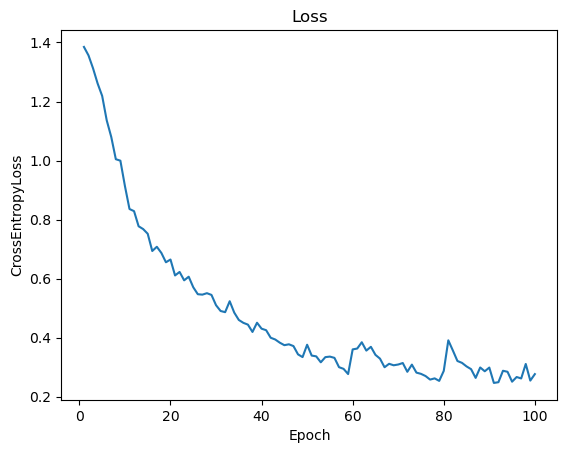

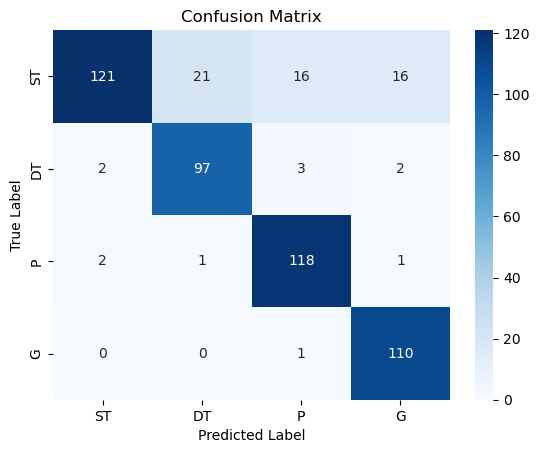

In [13]:
#plot loss & confusion matrix using seabon
confusionMatrixPlot = confusionMatrix.compute().numpy()
plt.figure(1)
sns.lineplot(x=range(1,n_epochs+1), y = epoch_loss)
plt.xlabel('Epoch')
plt.ylabel('CrossEntropyLoss')
plt.title('Loss')
plt.show()
plt.figure(2)
label_classes = ["ST", "DT", "P", "G"]
sns.heatmap(confusionMatrixPlot,annot=True,fmt= 'd',cmap='Blues', xticklabels=label_classes, yticklabels=label_classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# GRU

In [14]:
num_features = 4
num_classes = 4
time_window = 200

batch_size = 64
lr = 0.001
n_epochs = 100

network_type = 'GRU'
train_all_data = False # train a model using all avaiable data

# collision = False; localization = False; n_epochs = 15; batch_size = 64; num_classes = 5; lr = 0.001
# collision = True; localization = False; n_epochs = 120; batch_size = 64; num_classes = 2; lr = 0.001
# collision = False; localization = True; n_epochs = 110; batch_size =64; num_classes = 2; lr = 0.001

if __name__ == '__main__':
    # set random seed to 0
    torch.manual_seed(2020)
    np.random.seed(2020)
    random.seed(2020)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

    if device.type == "cuda":
        torch.cuda.get_device_name()
    
    # Load data and create training and testing sets
    # training_data = create_tensor_dataset_without_torque('../contactInterpretation-main/dataset/realData/contact_detection_train.csv',num_classes=num_classes, collision=collision, localization= localization, num_features=num_features)
    # testing_data = create_tensor_dataset_without_torque('../contactInterpretation-main/dataset/realData/contact_detection_test.csv',num_classes=num_classes, collision=collision, localization= localization,num_features=num_features)
    training_data = create_tensor_dataset('../DATA/tactile_dataset_block_train.csv')
    testing_data = create_tensor_dataset('../DATA/tactile_dataset_block_test.csv')

    
    train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle= True)
    test_dataloader = DataLoader(testing_data, batch_size=batch_size, shuffle= True)
    
    train_features, train_labels = next(iter(train_dataloader))
    print(f"Feature batch shape: {train_features.size()}")
    print(f"Labels batch shape: {train_labels.size()}")

    # Build the model  
    model= Sequence(network_type)
    model = model.double()
    # Use Adam optimizer and CrossEntropyLoss as the loss function
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    model.train()


    # Training loop
    epoch_loss = []
    for epoch in range(n_epochs):
        running_loss = []
        index_i = 0
        for X_batch, y_batch in train_dataloader:
            # print(X_batch.shape)
            # print(X_batch)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            #torch.argmax(y_pred, dim=1)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            running_loss.append(loss.cpu().detach().numpy())
        if train_all_data: 
            for X_batch, y_batch in test_dataloader:
                optimizer.zero_grad()
                y_pred = model(X_batch)
                #torch.argmax(y_pred, dim=1)
                loss = loss_fn(y_pred, y_batch)
                loss.backward()
                optimizer.step()
                running_loss.append(loss.cpu().detach().numpy())
        print("Epoch: {}/{} - learning rate: {:.5f}, classification loss: {:.4f}".format(epoch + 1, n_epochs, optimizer.param_groups[0]['lr'], np.mean(running_loss)))
        epoch_loss.append(np.mean(running_loss))

    # Validation
    model.eval()
    
    with torch.no_grad():
        confusionMatrix = ConfusionMatrix(task = "multiclass", num_classes= num_classes)

        y_pred, y_test = get_output(testing_data, model)
        print("on the test set: \n",confusionMatrix(y_test , y_pred))

        y_pred, y_train = get_output(training_data, model)
        print("on the train set: \n",confusionMatrix(y_train , y_pred))

cuda:0
Feature batch shape: torch.Size([64, 7, 800])
Labels batch shape: torch.Size([64])
Epoch: 1/100 - learning rate: 0.00100, classification loss: 1.3477
Epoch: 2/100 - learning rate: 0.00100, classification loss: 1.2599
Epoch: 3/100 - learning rate: 0.00100, classification loss: 1.1834
Epoch: 4/100 - learning rate: 0.00100, classification loss: 1.1298
Epoch: 5/100 - learning rate: 0.00100, classification loss: 1.0413
Epoch: 6/100 - learning rate: 0.00100, classification loss: 1.0042
Epoch: 7/100 - learning rate: 0.00100, classification loss: 0.9226
Epoch: 8/100 - learning rate: 0.00100, classification loss: 0.8806
Epoch: 9/100 - learning rate: 0.00100, classification loss: 0.8270
Epoch: 10/100 - learning rate: 0.00100, classification loss: 0.8020
Epoch: 11/100 - learning rate: 0.00100, classification loss: 0.7735
Epoch: 12/100 - learning rate: 0.00100, classification loss: 0.7282
Epoch: 13/100 - learning rate: 0.00100, classification loss: 0.7304
Epoch: 14/100 - learning rate: 0.00

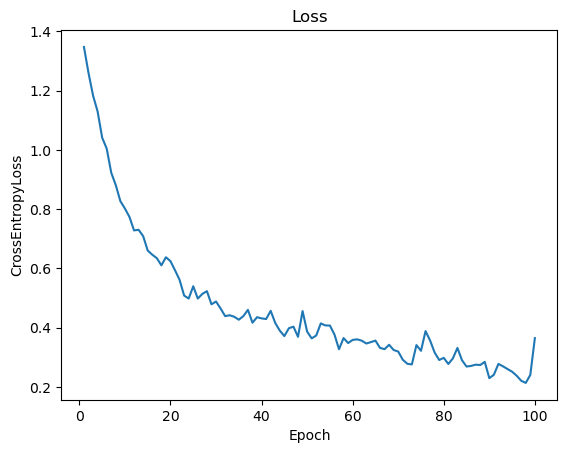

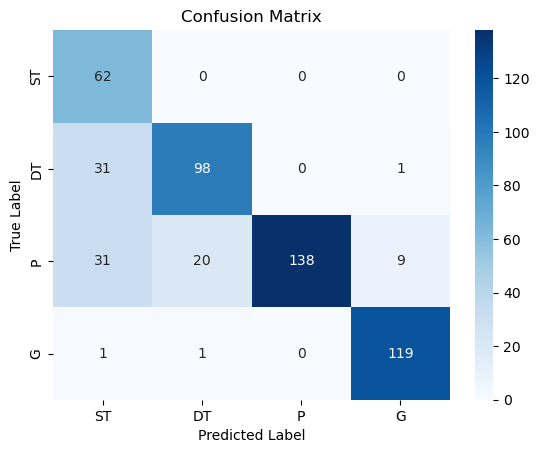

In [15]:
#plot loss & confusion matrix using seabon
confusionMatrixPlot = confusionMatrix.compute().numpy()
plt.figure(1)
sns.lineplot(x=range(1,n_epochs+1), y = epoch_loss)
plt.xlabel('Epoch')
plt.ylabel('CrossEntropyLoss')
plt.title('Loss')
plt.show()
plt.figure(2)
label_classes = ["ST", "DT", "P", "G"]
sns.heatmap(confusionMatrixPlot,annot=True,fmt= 'd',cmap='Blues', xticklabels=label_classes, yticklabels=label_classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Liquid NN

## FCLTC

In [24]:
num_features = 4
num_classes = 4
time_window = 200

batch_size = 64
lr = 0.0001
n_epochs = 200

network_type = 'NCPCfC'
train_all_data = False # train a model using all avaiable data

# collision = False; localization = False; n_epochs = 15; batch_size = 64; num_classes = 5; lr = 0.001
# collision = True; localization = False; n_epochs = 120; batch_size = 64; num_classes = 2; lr = 0.001
# collision = False; localization = True; n_epochs = 110; batch_size =64; num_classes = 2; lr = 0.001

if __name__ == '__main__':
    # set random seed to 0
    torch.manual_seed(2020)
    np.random.seed(2020)
    random.seed(2020)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

    if device.type == "cuda":
        torch.cuda.get_device_name()
    
    # Load data and create training and testing sets
    # training_data = create_tensor_dataset_without_torque('../contactInterpretation-main/dataset/realData/contact_detection_train.csv',num_classes=num_classes, collision=collision, localization= localization, num_features=num_features)
    # testing_data = create_tensor_dataset_without_torque('../contactInterpretation-main/dataset/realData/contact_detection_test.csv',num_classes=num_classes, collision=collision, localization= localization,num_features=num_features)
    training_data = create_tensor_dataset('../DATA/tactile_dataset_block_train.csv')
    testing_data = create_tensor_dataset('../DATA/tactile_dataset_block_test.csv')

    
    train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle= True)
    test_dataloader = DataLoader(testing_data, batch_size=batch_size, shuffle= True)
    
    train_features, train_labels = next(iter(train_dataloader))
    print(f"Feature batch shape: {train_features.size()}")
    print(f"Labels batch shape: {train_labels.size()}")

    # Build the model  
    model= Sequence(network_type)
    model = model.double()
    # Use Adam optimizer and CrossEntropyLoss as the loss function
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    model.train()


    # Training loop
    epoch_loss = []
    for epoch in range(n_epochs):
        running_loss = []
        index_i = 0
        for X_batch, y_batch in train_dataloader:
            # print(X_batch.shape)
            # print(X_batch)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            #torch.argmax(y_pred, dim=1)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            running_loss.append(loss.cpu().detach().numpy())
        if train_all_data: 
            for X_batch, y_batch in test_dataloader:
                optimizer.zero_grad()
                y_pred = model(X_batch)
                #torch.argmax(y_pred, dim=1)
                loss = loss_fn(y_pred, y_batch)
                loss.backward()
                optimizer.step()
                running_loss.append(loss.cpu().detach().numpy())
        print("Epoch: {}/{} - learning rate: {:.5f}, classification loss: {:.4f}".format(epoch + 1, n_epochs, optimizer.param_groups[0]['lr'], np.mean(running_loss)))
        epoch_loss.append(np.mean(running_loss))

    # Validation
    model.eval()
    
    with torch.no_grad():
        confusionMatrix = ConfusionMatrix(task = "multiclass", num_classes= num_classes)

        y_pred, y_test = get_output(testing_data, model)
        print("on the test set: \n",confusionMatrix(y_test , y_pred))

        y_pred, y_train = get_output(training_data, model)
        print("on the train set: \n",confusionMatrix(y_train , y_pred))

cuda:0
Feature batch shape: torch.Size([64, 7, 800])
Labels batch shape: torch.Size([64])
Epoch: 1/200 - learning rate: 0.00010, classification loss: 1.3905
Epoch: 2/200 - learning rate: 0.00010, classification loss: 1.3920
Epoch: 3/200 - learning rate: 0.00010, classification loss: 1.3888
Epoch: 4/200 - learning rate: 0.00010, classification loss: 1.3898
Epoch: 5/200 - learning rate: 0.00010, classification loss: 1.3870
Epoch: 6/200 - learning rate: 0.00010, classification loss: 1.3861
Epoch: 7/200 - learning rate: 0.00010, classification loss: 1.3847
Epoch: 8/200 - learning rate: 0.00010, classification loss: 1.3833
Epoch: 9/200 - learning rate: 0.00010, classification loss: 1.3823
Epoch: 10/200 - learning rate: 0.00010, classification loss: 1.3795
Epoch: 11/200 - learning rate: 0.00010, classification loss: 1.3752
Epoch: 12/200 - learning rate: 0.00010, classification loss: 1.3746
Epoch: 13/200 - learning rate: 0.00010, classification loss: 1.3719
Epoch: 14/200 - learning rate: 0.00

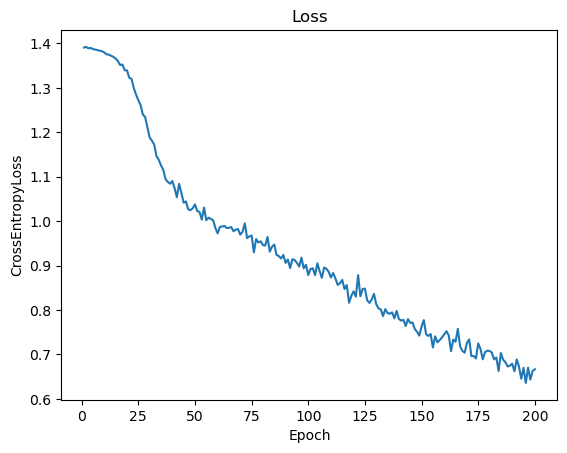

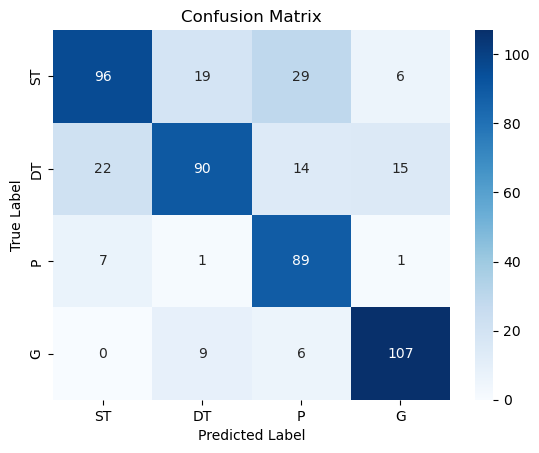

In [25]:
#plot loss & confusion matrix using seabon
confusionMatrixPlot = confusionMatrix.compute().numpy()
plt.figure(1)
sns.lineplot(x=range(1,n_epochs+1), y = epoch_loss)
plt.xlabel('Epoch')
plt.ylabel('CrossEntropyLoss')
plt.title('Loss')
plt.show()
plt.figure(2)
label_classes = ["ST", "DT", "P", "G"]
sns.heatmap(confusionMatrixPlot,annot=True,fmt= 'd',cmap='Blues', xticklabels=label_classes, yticklabels=label_classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()